In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.manifold import TSNE

In [2]:
!which python

/home/badr/anaconda3/bin/python


In [3]:
import torch
import torchaudio
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC


In [4]:
# Load pre-trained model and processor
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")


Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You sho

In [14]:
# Load an example audio file (replace with your own path)
audio_path = "/home/badr/explore_wav2vec/spoken_digit/speech_data/7_lucas_0.wav"
waveform, sample_rate = torchaudio.load(audio_path)

In [153]:
sample_rate

8000

In [152]:
waveform.shape, sample_rate

(torch.Size([1, 10598]), 8000)

In [203]:
import librosa
import IPython.display as ipd

# Specify the path to the audio file
#audio_path = "path/to/audio/file.wav"

# Read the audio file
audio, sr = librosa.load(audio_path, sr=8000)


# Play the audio in the notebook
audio_hat = audio[2200:]

print(len(audio), len(audio_hat), sr)

ipd.Audio(audio_hat, rate=sr)


5299 3099 8000


In [427]:
def plot_mel_spectrogram(audio, sr):

    # Set the frame length and stride
    frame_length = int(sr * 0.025)  # 25 milliseconds
    hop_length = int(sr * 0.020)  # 20 milliseconds

    # Compute the mel spectrogram
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=60, n_fft=frame_length, hop_length=hop_length)
    #spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr,  n_mels=128,)

    # Convert the power spectrogram to dB scale
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

    print(spectrogram_db.shape, sr)
    
    # Plot the mel spectrogram
    plt.figure(figsize=(8, 3))
    librosa.display.specshow(spectrogram_db, sr=sr, x_axis='frames', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.tight_layout()
    plt.show()

    return spectrogram_db


(60, 34) 8000


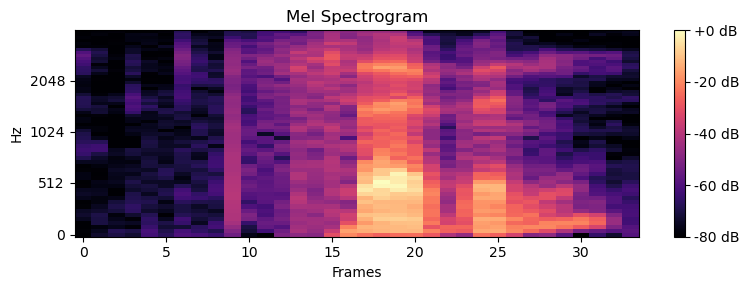

In [428]:
spec = plot_mel_spectrogram(audio, sr=sr)

(60, 20) 8000


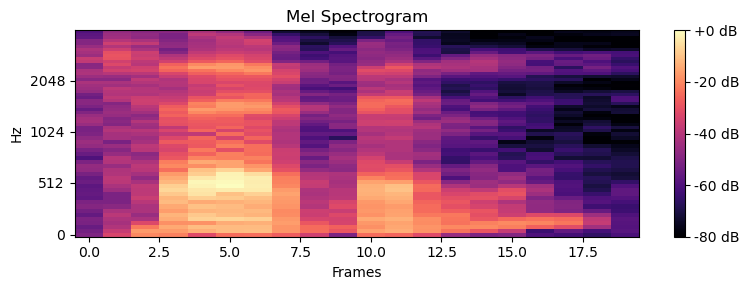

In [429]:
spec_2 = plot_mel_spectrogram(audio_hat, sr=sr)

0.9664389 0.028047511
(20, 20)


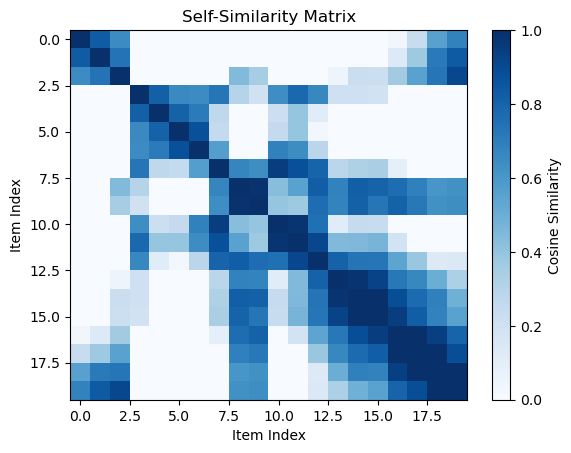

In [487]:
# Calculate cosine similarity matrix
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

similarity_matrix = cosine_similarity(spec_2.T)

sim_mean = np.mean(similarity_matrix)
sim_stddev = np.std(similarity_matrix)

print(sim_mean, sim_stddev)
similarity_matrix_adjusted = (similarity_matrix - sim_mean) / sim_stddev

print(similarity_matrix_adjusted.shape)

# Plot the self-similarity matrix
plt.imshow(similarity_matrix_adjusted, cmap='Blues', origin='upper', aspect='auto', vmin=0, vmax=1)
plt.title('Self-Similarity Matrix')
plt.xlabel('Item Index')
plt.ylabel('Item Index')
plt.colorbar(label='Cosine Similarity')
plt.show()

In [294]:
waveform.shape, sample_rate

(torch.Size([1, 6198]), 8000)

In [440]:
waveform, sample_rate = torchaudio.load(audio_path)
waveform = waveform.squeeze()[2200:].unsqueeze(dim=0)
print(waveform.shape)

resampler = torchaudio.transforms.Resample(8_000, 16_000) 
#speech_array, sampling_rate = torchaudio.load(batch["path"])
waveform = resampler(waveform)
print(waveform.shape)

torch.Size([1, 3099])
torch.Size([1, 6198])


In [441]:
# #speech_array, sampling_rate = torchaudio.load(batch["path"])
# waveform = resampler(waveform[0][2200:])
# waveform.shape, 

In [442]:
# Tokenize and forward pass through the model
input_values = processor(waveform.squeeze().numpy(), return_tensors="pt", sampling_rate=16000).input_values

with torch.no_grad():
    output = model(input_values, output_hidden_states=True)

input_values.shape

torch.Size([1, 6198])

In [443]:
 # retrieve logits
 logits = output.logits
 
 # take argmax and decode
 predicted_ids = torch.argmax(logits, dim=-1)
 transcription = processor.batch_decode(predicted_ids)

transcription

['SEVEN']

In [444]:
layer_reprs = output.hidden_states

layer_reprs[0].shape

torch.Size([1, 19, 768])

In [445]:
layer_reprs[0].shape, len(layer_reprs)

(torch.Size([1, 19, 768]), 13)

In [446]:
intermediate_layer_output = layer_reprs[0]

In [447]:
similarity_matrix.shape

(20, 20)

In [493]:
def plot_self_similarity_matrix(intermediate_layer_outputs, layer_index=0):
    # Calculate the self-similarity matrix
    #similarity_matrix = torch.cosine_similarity(intermediate_layer_outputs[layer_index].transpose(0, 1), 
    #    intermediate_layer_outputs[layer_index].transpose(0, 1), 
    #    dim=-1
    #)

    # Convert the tensor to a NumPy array
    #similarity_matrix_np = similarity_matrix.numpy()

    print(intermediate_layer_outputs[layer_index].shape)
    similarity_matrix = cosine_similarity(intermediate_layer_outputs[layer_index][0])
    
    sim_mean = similarity_matrix.mean()

    sim_stddev = np.std(similarity_matrix)

    print(sim_mean, sim_stddev)
    similarity_matrix_adjusted = similarity_matrix #- sim_mean) #/ sim_stddev

    #similarity_matrix = similarity_matrix - sim_mean


    print(similarity_matrix_adjusted.shape, sim_mean, sim_stddev)

    # Plot the self-similarity matrix
    plt.imshow(similarity_matrix_adjusted, cmap='Blues', origin='upper', aspect='auto', vmin=0, vmax=1)
    plt.title(f'Self-Similarity Matrix (Layer {layer_index})')
    plt.xlabel('Frame Index')
    plt.ylabel('Frame Index')
    plt.colorbar(label='Cosine Similarity')
    plt.show()


torch.Size([1, 19, 768])
0.18531914 0.26594937
(19, 19) 0.18531914 0.26594937


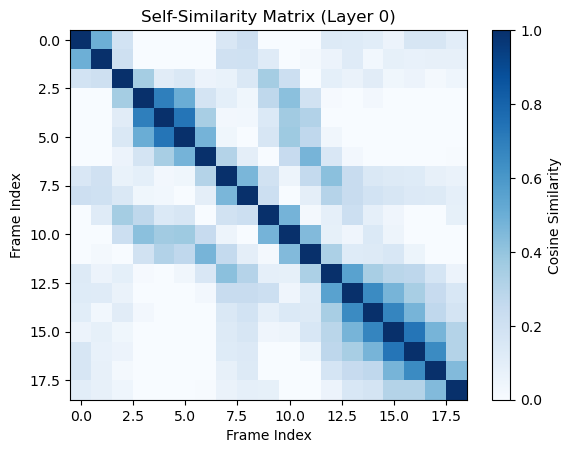

In [494]:
plot_self_similarity_matrix(layer_reprs, layer_index=0)

torch.Size([1, 19, 768])
0.9563174 0.029716637
(19, 19) 0.9563174 0.029716637


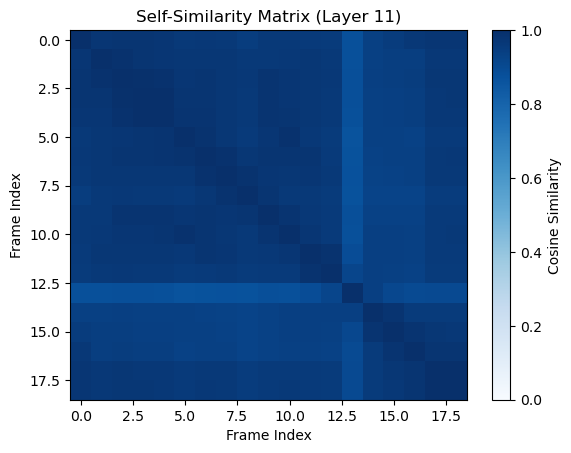

In [495]:
plot_self_similarity_matrix(layer_reprs, layer_index=11)

torch.Size([1, 19, 768])
0.25737625 0.33479968
(19, 19) 0.25737625 0.33479968


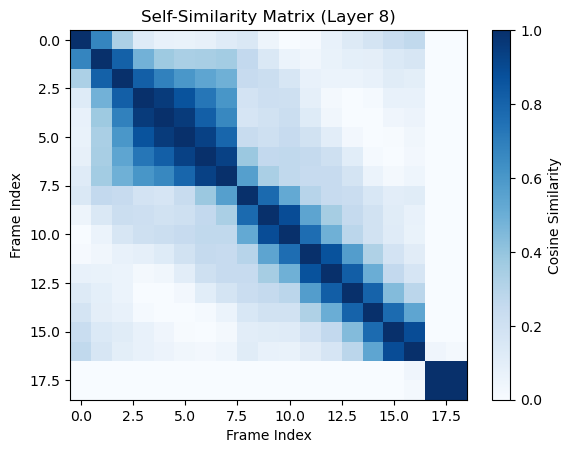

In [499]:
plot_self_similarity_matrix(layer_reprs, layer_index=8)

torch.Size([1, 19, 768])
0.9563174 0.029716637
(19, 19) 0.9563174 0.029716637


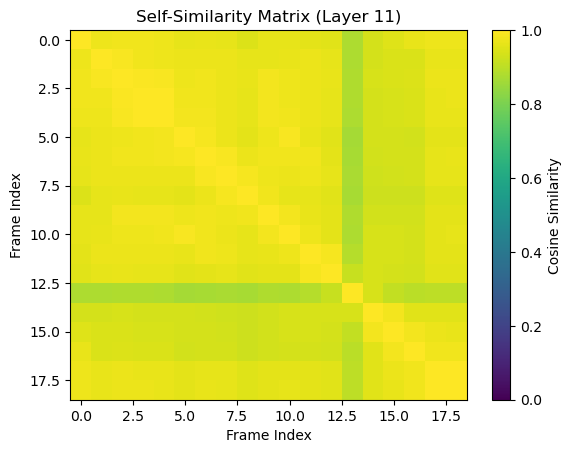

In [469]:
plot_self_similarity_matrix(layer_reprs, layer_index=11)